<a href="https://colab.research.google.com/github/HenrySomeCode/Classify-which-country-the-name-belongs-to-using-RNN-Pytorch/blob/main/Classify_which_country_the_name_belongs_to_using_RNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref:
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
zip_path = "/content/drive/MyDrive/AI_ML_DL Course_by_Master_Linh_HUST/week4/Me/data/data.zip"

In [5]:
!cp "{zip_path}" .

In [15]:
!unzip -q /content/data.zip

In [16]:
!rm data.zip

Preparing the data

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}.

In [1]:
from io import open
import glob
import os

In [20]:
import unicodedata
import string

In [2]:
def findFiles(path): return glob.glob(path)

In [19]:
print(findFiles("/content/data/names/*.txt"))

['/content/data/names/Arabic.txt', '/content/data/names/Vietnamese.txt', '/content/data/names/Greek.txt', '/content/data/names/French.txt', '/content/data/names/Dutch.txt', '/content/data/names/Portuguese.txt', '/content/data/names/Japanese.txt', '/content/data/names/Italian.txt', '/content/data/names/Polish.txt', '/content/data/names/Chinese.txt', '/content/data/names/Irish.txt', '/content/data/names/Scottish.txt', '/content/data/names/Russian.txt', '/content/data/names/Czech.txt', '/content/data/names/Korean.txt', '/content/data/names/English.txt', '/content/data/names/Spanish.txt', '/content/data/names/German.txt']


In [23]:
all_letters = string.ascii_letters + " .,;'"
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [24]:
n_letters = len(all_letters)
n_letters

57

In [31]:
for c in 'Ślusàrski':
    print(c)

Ś
l
u
s
à
r
s
k
i


In [34]:
for c in unicodedata.normalize('NFD','Ślusàrski'):
    print(c)

S
́
l
u
s
a
̀
r
s
k
i


In [35]:
for c in unicodedata.normalize('NFD','Ślusàrski'):
    print(unicodedata.category(c))
# 'L'etter, 'u'ppercase, 'l'owercase, 'M'ark, 'n'onspacing
# Besides: 'A'rabic, 'N'umber . Ref: https://www.fileformat.info/info/unicode/category/index.htm

Lu
Mn
Ll
Ll
Ll
Ll
Mn
Ll
Ll
Ll
Ll


In [25]:
#convert an Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [26]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [64]:
category_lines = {}
all_categories = []

In [65]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [44]:
lines = readLines('/content/data/names/Arabic.txt')
lines[:10]

['Khoury',
 'Nahas',
 'Daher',
 'Gerges',
 'Nazari',
 'Maalouf',
 'Gerges',
 'Naifeh',
 'Guirguis',
 'Baba']

In [66]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [67]:
n_categories = len(all_categories)

In [68]:
n_categories

18

In [69]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning names into tensors

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>

In [70]:
import torch

In [71]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [51]:
letterToIndex('b')

1

In [72]:
def letterToTensor(letter):
    # The extra 1 dimension is because PyTorch assumes everything is in batches
    # - we’re just using a batch size of 1 here.
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [53]:
letterToTensor('b')

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [73]:
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [74]:
lineToTensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

Creating the network

In [57]:
import torch.nn as nn

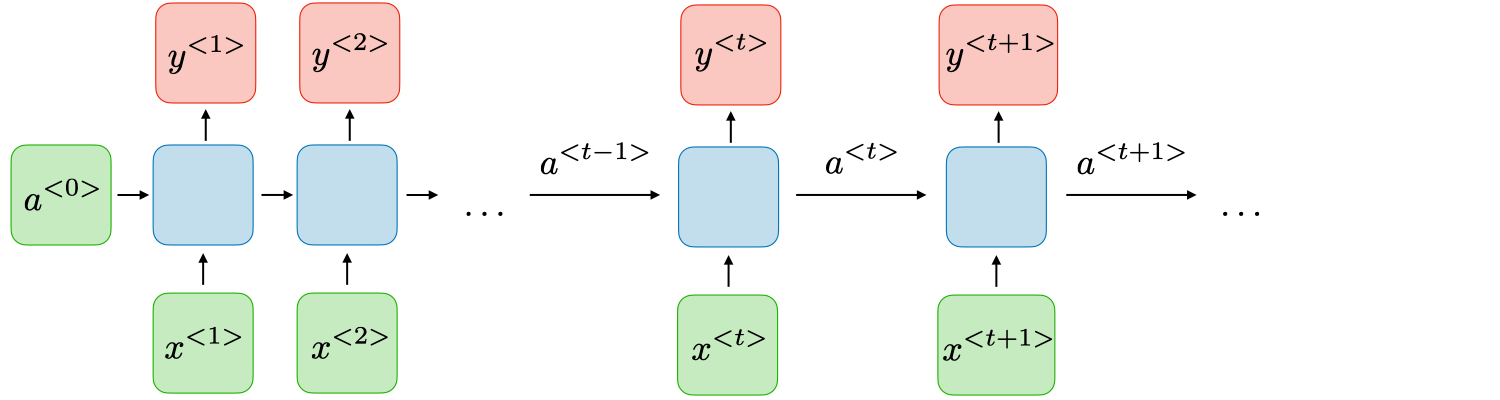

[source: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks]

In [75]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [76]:
n_categories

18

In [77]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [78]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)
output, next_hidden = rnn(input,hidden)

In [79]:
print(output)
print(next_hidden)

tensor([[-2.8514, -2.8727, -2.9588, -2.8684, -2.8951, -3.0014, -2.8435, -2.9101,
         -2.8075, -3.0025, -2.9857, -2.9099, -2.8268, -2.8168, -2.9557, -2.8278,
         -2.8328, -2.8950]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-6.3482e-02,  3.4098e-02, -1.7058e-02, -4.3865e-02, -9.7381e-03,
         -5.2626e-03,  1.1416e-01,  2.4196e-02, -1.3905e-02,  5.3837e-02,
          4.1028e-02,  3.8969e-02, -2.5519e-02,  5.9136e-03, -2.4847e-02,
         -6.0029e-02, -4.7071e-02,  6.1951e-02,  2.8623e-02,  1.8542e-02,
         -3.5676e-02,  5.2074e-03,  2.7744e-02,  9.6608e-04, -9.9613e-02,
         -5.9784e-03,  3.2584e-04, -2.9719e-02,  3.4730e-02, -6.5934e-02,
         -5.6213e-02, -5.2299e-02, -2.8767e-02, -1.0870e-02, -7.5144e-02,
          5.6038e-03,  3.6784e-02,  5.4718e-02,  3.3800e-02, -9.6302e-02,
          2.5029e-03,  7.0866e-02,  1.2310e-01,  8.6745e-02,  1.0755e-01,
         -6.1916e-02, -9.0636e-02,  3.6587e-02, -1.5196e-02,  1.1316e-02,
         -8.6008e-02,  1.2829e-02, -4.

In [80]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8514, -2.8727, -2.9588, -2.8684, -2.8951, -3.0014, -2.8435, -2.9101,
         -2.8075, -3.0025, -2.9857, -2.9099, -2.8268, -2.8168, -2.9557, -2.8278,
         -2.8328, -2.8950]], grad_fn=<LogSoftmaxBackward0>)


Training

In [81]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [82]:
print(categoryFromOutput(output))

('Polish', 8)


We will also want a quick way to get a training example (a name and its language) to use during training process.

The reason why [Sean Robertson](https://github.com/spro) don't loop all over the training set is unknown .My assumption is that:

He don't split data into train, val, test. So it's kinda bad if we train our model on the whole data and use it to make prediction on the same data.

Instead, during training process, we use random example (a name and its language).


In [88]:
import random

In [89]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [90]:
randomChoice(all_categories)

'Irish'

In [93]:
torch.tensor([all_categories.index('Irish')], dtype=torch.long)

tensor([10])

In [94]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [96]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, '/ category_tensor =', category_tensor)

category = Czech / line = Kulhanek / category_tensor = tensor([13])
category = Arabic / line = Shamoon / category_tensor = tensor([0])
category = Polish / line = Sokolsky / category_tensor = tensor([8])
category = Dutch / line = Can / category_tensor = tensor([4])
category = Dutch / line = Klerkx / category_tensor = tensor([4])
category = Irish / line = O'Rourke / category_tensor = tensor([10])
category = Italian / line = Grimaldi / category_tensor = tensor([7])
category = Russian / line = Eimontov / category_tensor = tensor([12])
category = Polish / line = Czajkowski / category_tensor = tensor([8])
category = Czech / line = Pavlu / category_tensor = tensor([13])


In [85]:
# I have not studied about this loss, either on the course or by myself
criterion = nn.NLLLoss()

In [84]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    #Sets gradients of all model parameters to zero
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # w* = w -n*gradient
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [83]:
import time
import math

In [87]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

In [97]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [98]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.5675 Haanraats / Greek ✗ (Dutch)
10000 10% (0m 13s) 2.6790 Fakhoury / Irish ✗ (Arabic)
15000 15% (0m 20s) 1.4704 Gransky / Russian ✓
20000 20% (0m 27s) 0.6439 Wilson / Scottish ✓
25000 25% (0m 34s) 1.6115 Bang / Chinese ✗ (Korean)
30000 30% (0m 40s) 2.9061 Toman / Irish ✗ (Czech)
35000 35% (0m 46s) 3.0659 Patrick / Czech ✗ (Irish)
40000 40% (0m 53s) 1.4483 Vrazel / Czech ✓
45000 45% (0m 59s) 0.9619 Prinz / German ✓
50000 50% (1m 6s) 2.2545 Gorskin / Scottish ✗ (Russian)
55000 55% (1m 12s) 1.2964 Madden / Irish ✓
60000 60% (1m 19s) 0.5464 Santos / Portuguese ✓
65000 65% (1m 25s) 0.6623 Jukovich / Russian ✓
70000 70% (1m 32s) 1.6377 Rubio / Portuguese ✗ (Spanish)
75000 75% (1m 37s) 0.4779 Bach / Vietnamese ✓
80000 80% (1m 44s) 0.0276 Tatsuya / Japanese ✓
85000 85% (1m 50s) 0.9068 Tomasek / Polish ✗ (Czech)
90000 90% (1m 56s) 0.1316 Behoev / Russian ✓
95000 95% (2m 3s) 0.6075 Chun / Korean ✓
100000 100% (2m 9s) 1.6813 Hanraets / English ✗ (Dutch)


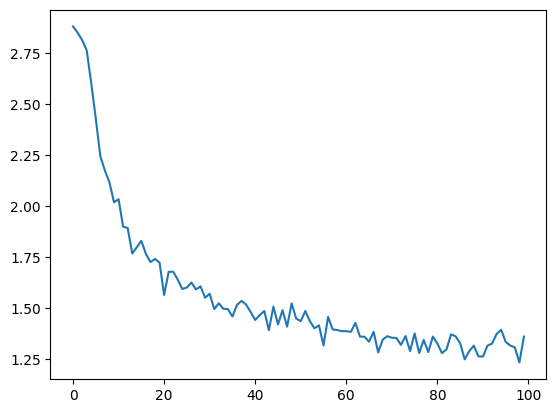

In [99]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns).

In [100]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [101]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [102]:
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [103]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

<ipython-input-107-077bea1f1a1d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-107-077bea1f1a1d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


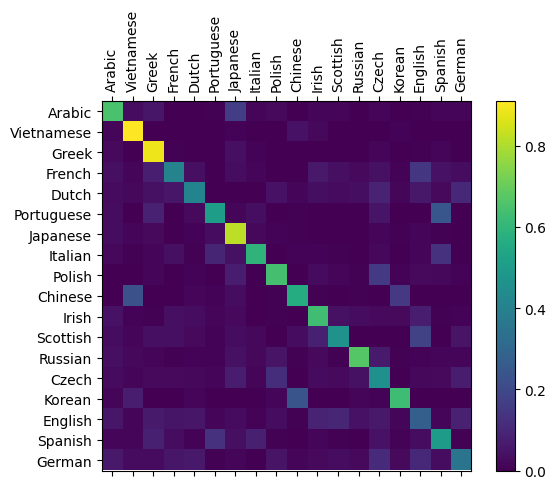

In [107]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

<ipython-input-105-58da21b0e0c2>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-105-58da21b0e0c2>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


In [106]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.34) Czech
(-1.50) Russian
(-3.63) English

> Jackson
(-0.46) Scottish
(-2.15) English
(-2.81) Greek

> Satoshi
(-0.88) Japanese
(-1.18) Italian
(-2.32) Polish
